# WGAN-GP (Wasserstein GAN con Gradient Penalty)

Este cuaderno implementa la arquitectura WGAN-GP para abordar los problemas de estabilidad y calidad de la GAN estándar.

**Diferencias Clave con GAN Estándar:**
1.  **Función de Pérdida:** Distancia de Wasserstein en lugar de BCE.
2.  **Critic (Crítico):** El discriminador ya no clasifica (0 o 1), sino que puntúa la "realidad". Se elimina la sigmoide final.
3.  **Gradient Penalty:** Se penaliza la norma del gradiente para cumplir la restricción 1-Lipschitz, en lugar de recortar pesos (weight clipping).
4.  **Entrenamiento:** El Crítico se entrena más veces (5) por cada actualización del Generador.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import sys
import os

# Añadir el directorio raíz al path
sys.path.append(os.path.abspath('..'))

from src.data_loader import download_data
from src.preprocessing import DataPreprocessor, create_sequences

## 1. Carga y Preparación de Datos

In [2]:
# Configuración
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-11-29'
SEQ_LEN = 24
BATCH_SIZE = 64
DATA_DIR = '../data/raw'

# Cargar datos
csv_filename = f"{TICKER}_{START_DATE}_{END_DATE}.csv"
csv_path = os.path.join(DATA_DIR, csv_filename)

if os.path.exists(csv_path):
    print(f"Cargando datos existentes desde: {csv_path}")
    df = pd.read_csv(csv_path, header=0, skiprows=[1, 2], index_col=0, parse_dates=True)
    df.index.name = 'Date'
else:
    print(f"Descargando datos...")
    df = download_data(TICKER, START_DATE, END_DATE, save_dir=DATA_DIR)

# Preprocesar
preprocessor = DataPreprocessor()
data_scaled = preprocessor.fit_transform(df, ['Close'])
sequences = create_sequences(data_scaled, SEQ_LEN)

# DataLoader
X_train = torch.tensor(sequences, dtype=torch.float32)
dataset = TensorDataset(X_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Datos de entrenamiento: {X_train.shape}")

Cargando datos existentes desde: ../data/raw/AAPL_2015-01-01_2025-11-29.csv
Datos de entrenamiento: torch.Size([2720, 24, 1])


## 2. Definición de Modelos (Generator & Critic)

El **Critic** es similar al Discriminador anterior pero **SIN** función de activación Sigmoid en la salida.

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid() # Mantenemos Sigmoid porque los datos están normalizados [0, 1]

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return self.sigmoid(output)

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_dim, output_dim)
        # SIN SIGMOID: El critic devuelve un "score" de realidad, no una probabilidad

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]
        output = self.linear(last_hidden)
        return output

## 3. Configuración WGAN-GP

Hiperparámetros específicos para WGAN-GP.

In [4]:
# Hiperparámetros WGAN-GP
NOISE_DIM = 10
HIDDEN_DIM = 64
FEATURE_DIM = 1
NUM_EPOCHS = 200
LR = 0.0001        # LR más bajo suele funcionar mejor en WGAN
BETA1 = 0.0        # Beta1 = 0 es crucial para WGAN-GP
BETA2 = 0.9
LAMBDA_GP = 10     # Coeficiente de penalización de gradiente estándar
N_CRITIC = 5       # Número de actualizaciones del Critic por cada una del Generator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciar
generator = Generator(input_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM, output_dim=FEATURE_DIM, num_layers=2).to(device)
critic = Critic(input_dim=FEATURE_DIM, hidden_dim=HIDDEN_DIM, output_dim=1, num_layers=2).to(device)

# Optimizadores (Sin Loss function explícita como BCELoss, la definimos manualmente)
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_C = optim.Adam(critic.parameters(), lr=LR, betas=(BETA1, BETA2))

## 4. Función Gradient Penalty

In [5]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Calcula la penalización del gradiente para forzar la restricción 1-Lipschitz."""
    # Interpolación aleatoria entre muestras reales y falsas
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    # Expandir alpha para que coincida con las dimensiones (batch, seq, features)
    # real_samples shape: (batch, seq, features)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    fake = torch.ones(d_interpolates.size(), requires_grad=False).to(device)
    
    # Calcular gradientes de las salidas del critic con respecto a las entradas interpoladas
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Aplanar gradientes para calcular la norma
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

## 5. Bucle de Entrenamiento WGAN-GP

In [6]:
G_losses = []
C_losses = []

print("Iniciando entrenamiento WGAN-GP...")

for epoch in tqdm(range(NUM_EPOCHS)):
    for i, (real_data,) in enumerate(dataloader):
        real_data = real_data.to(device)
        batch_size = real_data.size(0)
        
        # --- Entrenar Critic ---
        for _ in range(N_CRITIC):
            optimizer_C.zero_grad()
            
            # Generar datos falsos
            z = torch.randn(batch_size, SEQ_LEN, NOISE_DIM).to(device)
            fake_data = generator(z)
            
            # Puntuaciones del Critic
            critic_real = critic(real_data)
            critic_fake = critic(fake_data.detach())
            
            # Gradient Penalty
            gp = compute_gradient_penalty(critic, real_data, fake_data.detach(), device)
            
            # Loss del Critic (Wasserstein Loss con GP)
            # Queremos maximizar (D(real) - D(fake)), que es equivalente a minimizar -(D(real) - D(fake))
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            
            loss_critic.backward()
            optimizer_C.step()

        # --- Entrenar Generator ---
        # Solo una vez por cada N_CRITIC actualizaciones del critic
        optimizer_G.zero_grad()
        
        # Generar nuevos datos falsos para actualizar G
        # (Es importante no reusar los del bucle del critic para que el grafo de computación sea correcto)
        z = torch.randn(batch_size, SEQ_LEN, NOISE_DIM).to(device)
        fake_data = generator(z)
        
        critic_fake = critic(fake_data)
        
        # Loss del Generator
        # Queremos maximizar D(fake), equivalente a minimizar -D(fake)
        loss_generator = -torch.mean(critic_fake)
        
        loss_generator.backward()
        optimizer_G.step()

    G_losses.append(loss_generator.item())
    C_losses.append(loss_critic.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | C Loss: {loss_critic.item():.4f} | G Loss: {loss_generator.item():.4f}")

print("Entrenamiento finalizado.")

Iniciando entrenamiento WGAN-GP...


 10%|█         | 20/200 [04:13<37:41, 12.57s/it]

Epoch [20/200] | C Loss: -1.0456 | G Loss: 2.1136


 20%|██        | 40/200 [08:15<31:38, 11.87s/it]

Epoch [40/200] | C Loss: -0.4444 | G Loss: 1.6733


 30%|███       | 60/200 [12:12<27:41, 11.87s/it]

Epoch [60/200] | C Loss: -0.3157 | G Loss: 0.9740


 40%|████      | 80/200 [16:13<24:32, 12.27s/it]

Epoch [80/200] | C Loss: -0.1884 | G Loss: 1.0481


 50%|█████     | 100/200 [20:29<21:04, 12.64s/it]

Epoch [100/200] | C Loss: 0.0583 | G Loss: 1.0765


 60%|██████    | 120/200 [24:44<16:45, 12.57s/it]

Epoch [120/200] | C Loss: -0.0418 | G Loss: 0.9622


 70%|███████   | 140/200 [28:45<12:08, 12.15s/it]

Epoch [140/200] | C Loss: -0.1270 | G Loss: 1.0897


 80%|████████  | 160/200 [33:00<08:05, 12.13s/it]

Epoch [160/200] | C Loss: 0.1407 | G Loss: 1.0344


 90%|█████████ | 180/200 [37:02<04:01, 12.07s/it]

Epoch [180/200] | C Loss: -0.0099 | G Loss: 0.6736


100%|██████████| 200/200 [41:19<00:00, 12.40s/it]

Epoch [200/200] | C Loss: -0.1378 | G Loss: 0.2098
Entrenamiento finalizado.


## 6. Evaluación

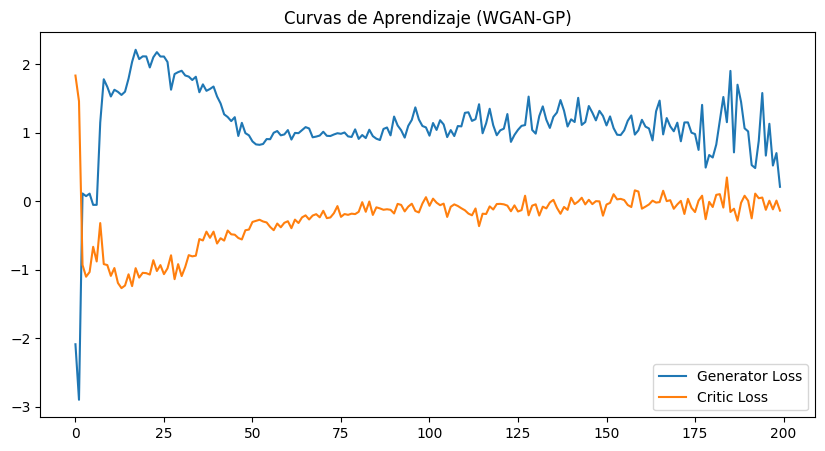

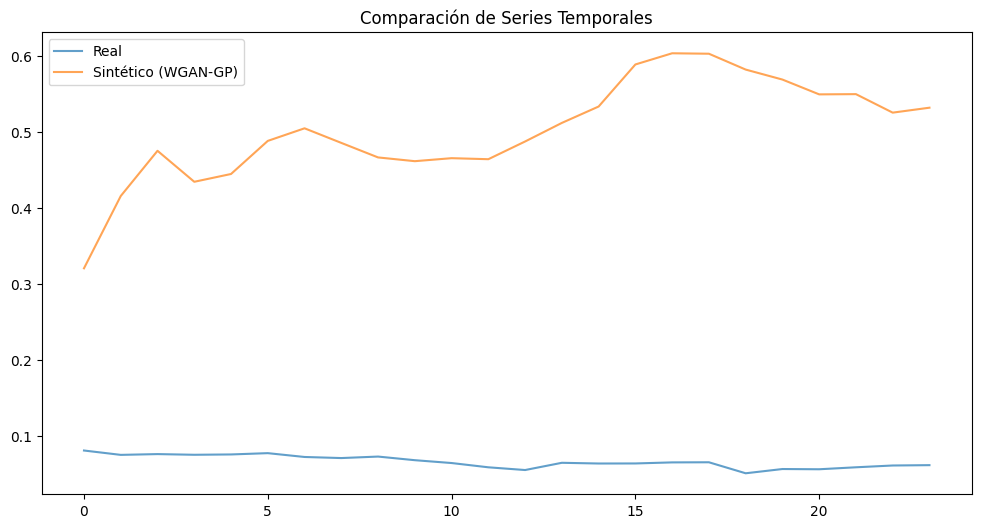

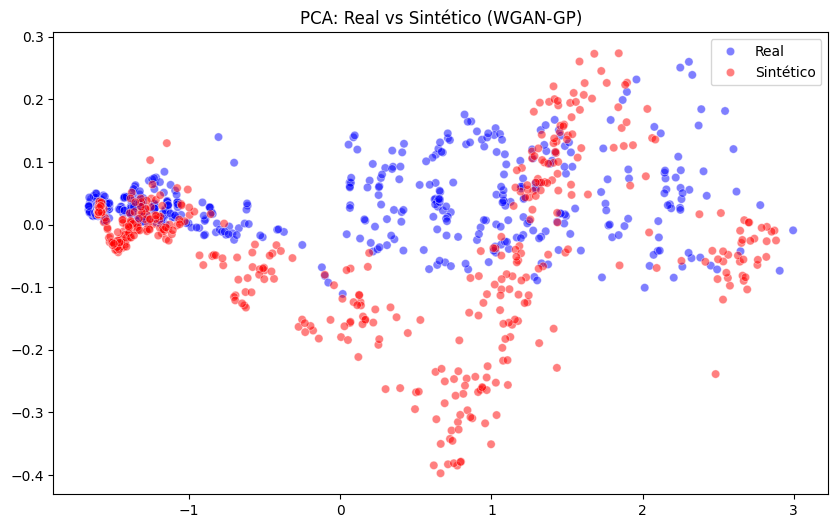

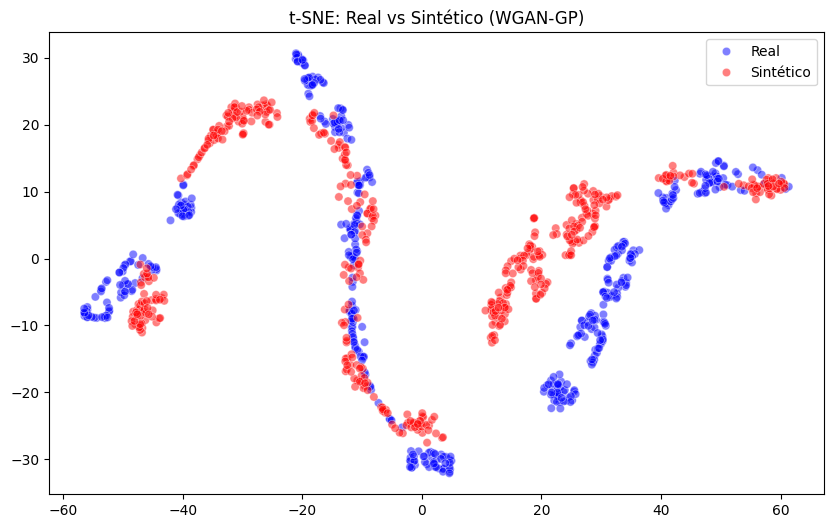

In [7]:
# 1. Gráfica de Pérdidas
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(C_losses, label="Critic Loss")
plt.title("Curvas de Aprendizaje (WGAN-GP)")
plt.legend()
plt.show()

# 2. Generar datos para evaluación
num_eval_samples = 500
generator.eval()
with torch.no_grad():
    z = torch.randn(num_eval_samples, SEQ_LEN, NOISE_DIM).to(device)
    synthetic_data = generator(z).cpu().numpy().squeeze()

# Tomar muestras reales
indices = np.random.choice(len(sequences), num_eval_samples, replace=False)
real_samples = sequences[indices].squeeze()

# 3. Comparación Visual de Series
plt.figure(figsize=(12, 6))
plt.plot(real_samples[0], label="Real", alpha=0.7)
plt.plot(synthetic_data[0], label="Sintético (WGAN-GP)", alpha=0.7)
plt.title("Comparación de Series Temporales")
plt.legend()
plt.show()

# 4. PCA
combined_data = np.concatenate([real_samples, synthetic_data], axis=0)
labels = np.array(['Real'] * num_eval_samples + ['Sintético'] * num_eval_samples)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=labels, alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title("PCA: Real vs Sintético (WGAN-GP)")
plt.show()

# 5. t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title("t-SNE: Real vs Sintético (WGAN-GP)")
plt.show()

In [9]:
# Guardar modelo WGAN
save_path = "../models/generator_wgan.pth"
torch.save(generator.state_dict(), save_path)
print(f"Modelo WGAN guardado en: {save_path}")

Modelo WGAN guardado en: ../models/generator_wgan.pth
